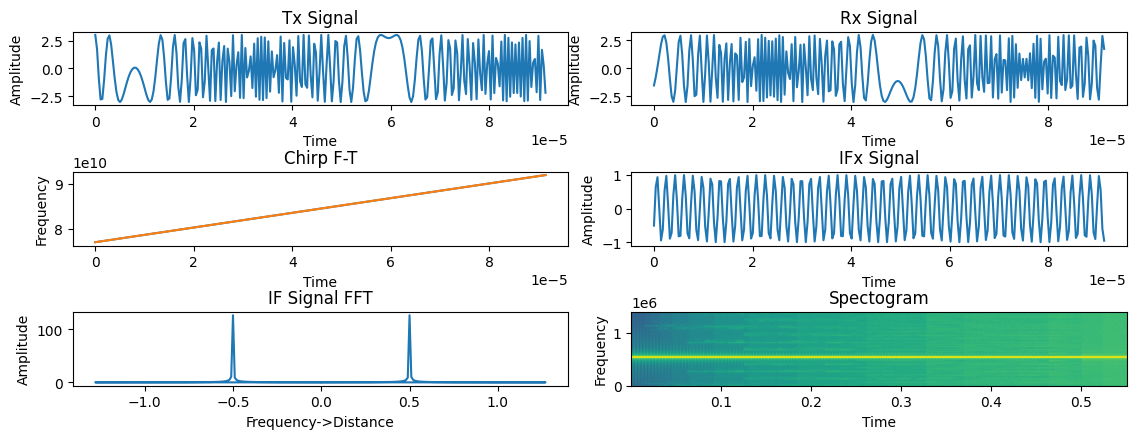

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D

#Radar parameters setting

maxR = 11
rangeRes = 0.01
maxV = 70 
fc = 77e9
c = 3e8 

r0 = 0.5
v0 = 0

B = c/(2*rangeRes)
# Tchirp = 5.5*2*maxR/c
Tchirp = 91.72 * (1e-6)
endle_time = 6.3e-6
slope = B/Tchirp 
f_IFmax = (slope*2*maxR)/c
f_IF = (slope*2*r0)/c 
Nd =  6000
Nr = 256
SAMPLE_COUNT_CHIRP =256
vres = (c/fc)/(2*Nd*(Tchirp+endle_time)) 
Fs = Nr/Tchirp 
#Tx = np.zeros(1,len(t))
#Rx = np.zeros(1,len(t)) 
#Mix = np.zeros(1,len(t)) 


amplitude_TX=3
amplitude_RX=3

t = np.linspace(0,Nd*Tchirp,Nr*Nd,endpoint=False) 
angle_freq = fc*t+(slope*t*t)/2 
freq = fc + slope*t 
Tx = amplitude_TX *np.cos(2*np.pi*angle_freq)

plt.figure(figsize=(12,6))

plt.subplot(4,2,1)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],Tx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],freq[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Tx F-T')

r0 = r0+v0*t


td = 2*r0/c
tx = t
freqRx = fc + slope*(t)


breathing_freq = 0.5  # Frequency in Hz
heart_freq = 3  # Frequency in Hz
vibration_amplitude_mm = 0.01  # Amplitude of the signal
duration = 300  # Duration in seconds
sampling_rate = 20*256  # Sampling rate in Hz

# Time array
breath_time = np.arange(0, duration, 1 / sampling_rate)
heart_time = np.arange(0, duration, 1 / sampling_rate)

# Calculate target vibration displacement profile (using a sinusoidal function for breathing-like motion)
vibration_displacement = vibration_amplitude_mm * np.sin(2 * np.pi * breathing_freq * breath_time)
vibration_displacement_heart = vibration_amplitude_mm * np.sin(2 * np.pi * heart_freq * heart_time)



# Calculate the phase shift for the vibration effect in received signal
#phase_shift = -2 * np.pi * fc * (vibration_displacement / c)
Rx = amplitude_RX *np.cos(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2)) #接受波形函数


plt.subplot(4,2,2)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],Rx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:SAMPLE_COUNT_CHIRP]+td[0:SAMPLE_COUNT_CHIRP],freqRx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Chirp F-T')

phase_shift=0
phase_shift+=(4 * np.pi * (r0+vibration_displacement))/0.04 
# phase_shift +=(4 * np.pi * (r0+vibration_displacement_heart))/0.04
IF_angle_freq = fc*t+(slope*t*t)/2 - ((fc*(t-td) + (slope*(t-td)*(t-td))/2))
freqIF = slope*td
IFx = np.cos(-(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2))+(2*np.pi*angle_freq)+phase_shift)




# IFx = Rx * np.conj(Tx)
plt.subplot(4,2,4)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],IFx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('IFx Signal')

#Range FFT
# doppler = 10*np.log10(np.abs(np.fft.fft(IFx[0:1024])))
doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_freq = frequency*c/(2*slope)
plt.subplot(4,2,5)
plt.plot(range_freq[0:SAMPLE_COUNT_CHIRP],doppler[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Frequency->Distance')
plt.ylabel('Amplitude')
plt.title('IF Signal FFT')

#2D plot
plt.subplot(4,2,6)
plt.specgram(IFx,SAMPLE_COUNT_CHIRP,Fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectogram')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()



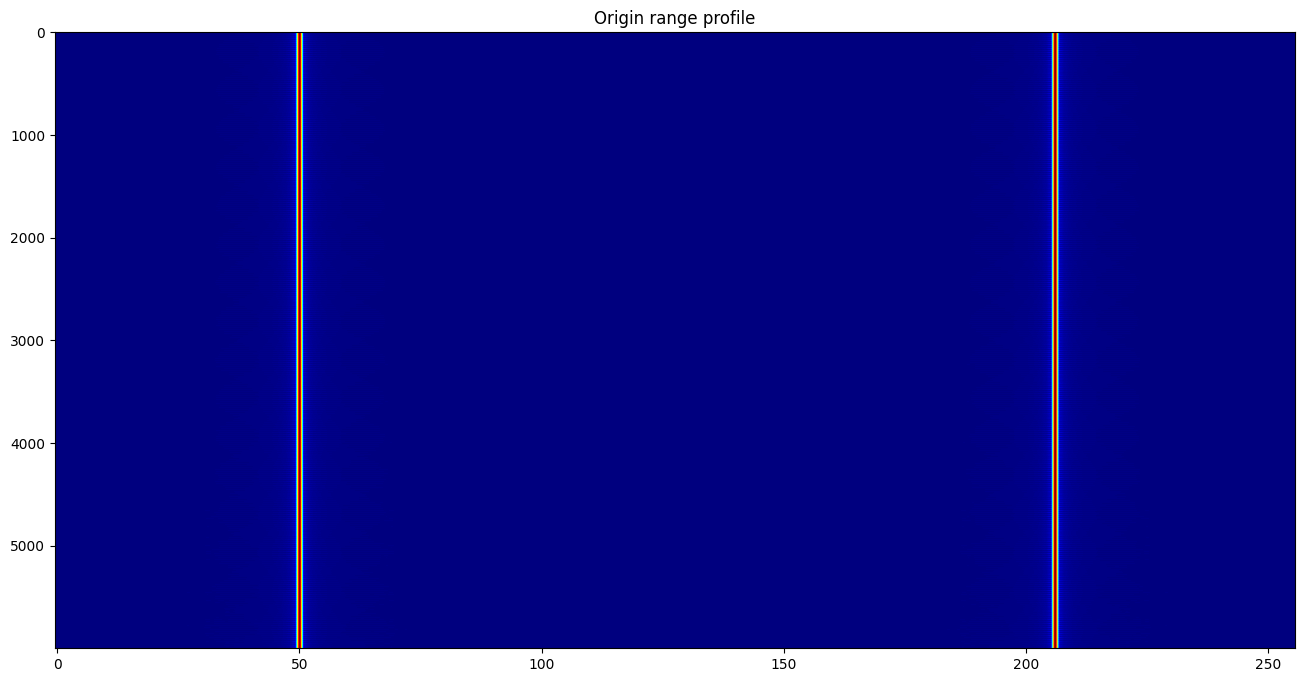

In [344]:
IFMatrix =IFx.reshape(Nd,Nr)
# rangeProfiles =[np.fft.fft (IFSignal) for IFSignal in  IFMatrix]
rangeProfiles =np.fft.fft (IFMatrix,axis=1)

freqs = np.fft.fftfreq(len(rangeProfiles[0]), 1/Fs)
magnitude_range_profile = [np.abs(profile) for profile in rangeProfiles]


doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_fre = frequency*c/(2*slope)

plt.figure(figsize=(16,8))
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')

plt.title("Origin range profile")
plt.show()


In [345]:
range_profile_shape = np.array(rangeProfiles).shape
range_bin = range_profile_shape[1]
frame_number =range_profile_shape[0]

estimated_background_range_profile = np.zeros(range_bin,dtype=complex)
for bin_index in range (0,range_bin):
    estimated_background_range_profile[bin_index] = np.average(np.array(rangeProfiles)[:,bin_index])
print("background estimation: ",estimated_background_range_profile.shape)

removal_background_range_profile =np.zeros_like(rangeProfiles)


for  bin_index in range (0,range_bin):
    for frame_index in range(0,frame_number):
        removal_background_range_profile [frame_index][bin_index] = rangeProfiles[frame_index][bin_index] - estimated_background_range_profile[bin_index]
print("background removal range profile: ",removal_background_range_profile.shape)   

background estimation:  (256,)
background removal range profile:  (6000, 256)


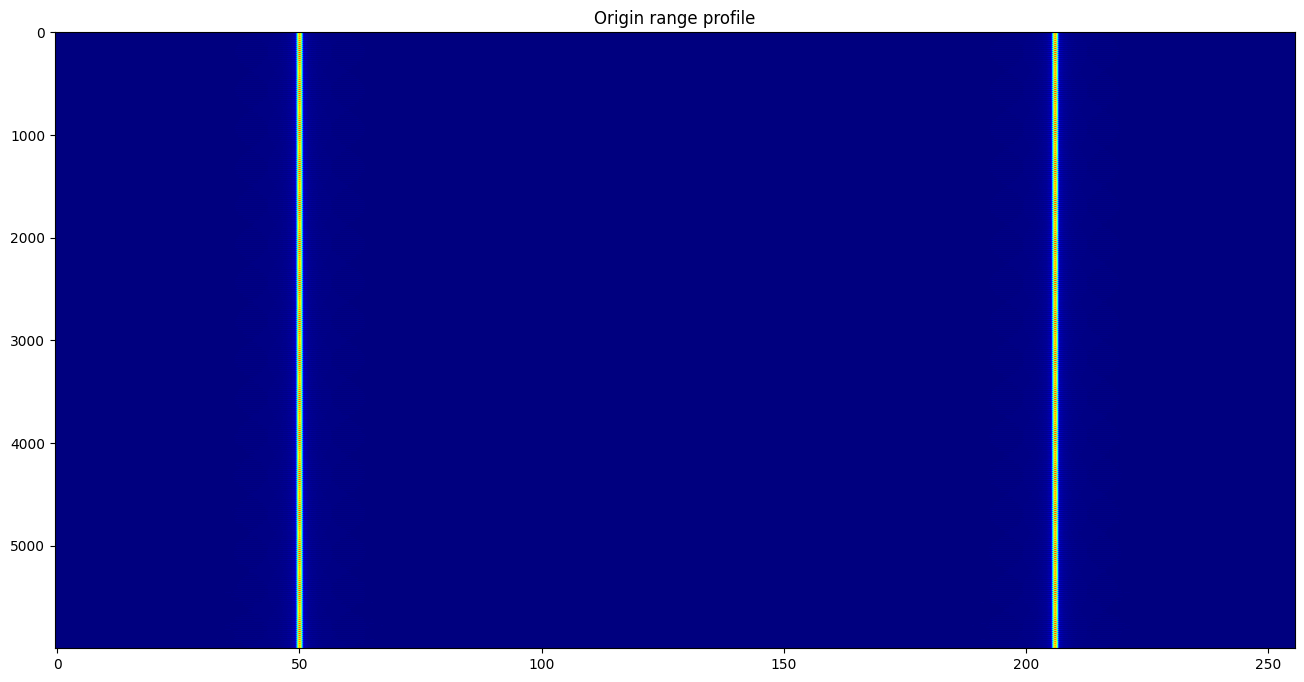

In [346]:
magnitude_range_profile = [np.abs(profile) for profile in removal_background_range_profile]
doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_fre = frequency*c/(2*slope)

plt.figure(figsize=(16,8))
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')

plt.title("Origin range profile")
plt.show()


In [347]:
magnitude_range_profile_shape =np.array(magnitude_range_profile).shape
print(magnitude_range_profile_shape[0])

6000


In [348]:
max_indices =[0]*magnitude_range_profile_shape[0]
for mag_profile in magnitude_range_profile:
    max_index = np.argmax(mag_profile)
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print(interesting_bin)

50


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


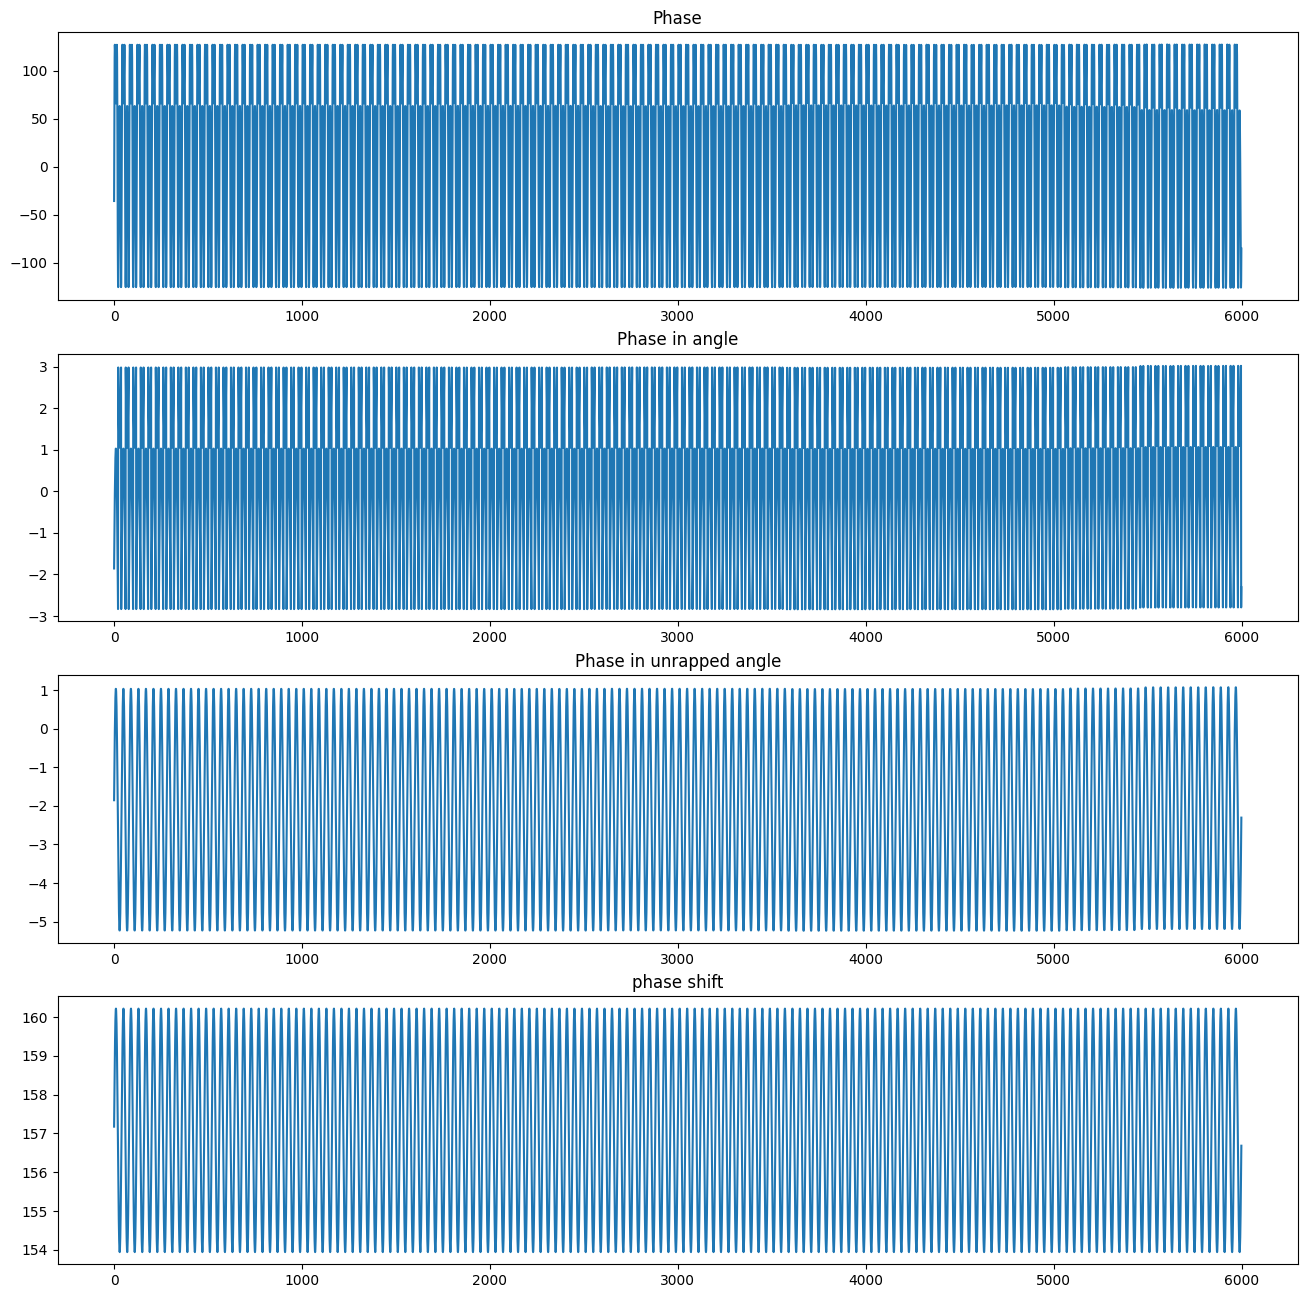

In [349]:
phase_row = phase_shift.reshape(Nd,Nr)
interest_bin_phase = np.array(rangeProfiles)[:,interesting_bin]
interest_bin_angle = np.angle(interest_bin_phase)
interest_bin_angle_unwrapped= np.unwrap(interest_bin_angle)
plt.figure(figsize=(16,16))
plt.subplot(411)
plt.plot(interest_bin_phase)
plt.title("Phase")
plt.subplot(412)
plt.plot(interest_bin_angle)
plt.title("Phase in angle")
plt.subplot(413)
plt.plot(interest_bin_angle_unwrapped)
plt.title("Phase in unrapped angle")
plt.subplot(414)
plt.plot(phase_row[:,interesting_bin])

plt.title("phase shift")
plt.show()



In [350]:

complex_number_i = np.empty(len(phase_shift),dtype=complex)
for i_phase,phase in enumerate(phase_shift):
    real_component = vibration_amplitude_mm * np.cos(phase)
    imaginary_component = vibration_amplitude_mm * np.sin(phase)
    complex_number = complex(real_component, imaginary_component)
    complex_number_i[i_phase]=complex_number

In [351]:
complex_interesting_bin = np.empty(len(interest_bin_angle_unwrapped),dtype=complex)
for i_phase,phase in enumerate(interest_bin_angle_unwrapped):
    real_component = vibration_amplitude_mm * np.cos(phase)
    imaginary_component = vibration_amplitude_mm * np.sin(phase)
    complex_phase = complex(real_component, imaginary_component)
    complex_interesting_bin[i_phase]=complex_phase

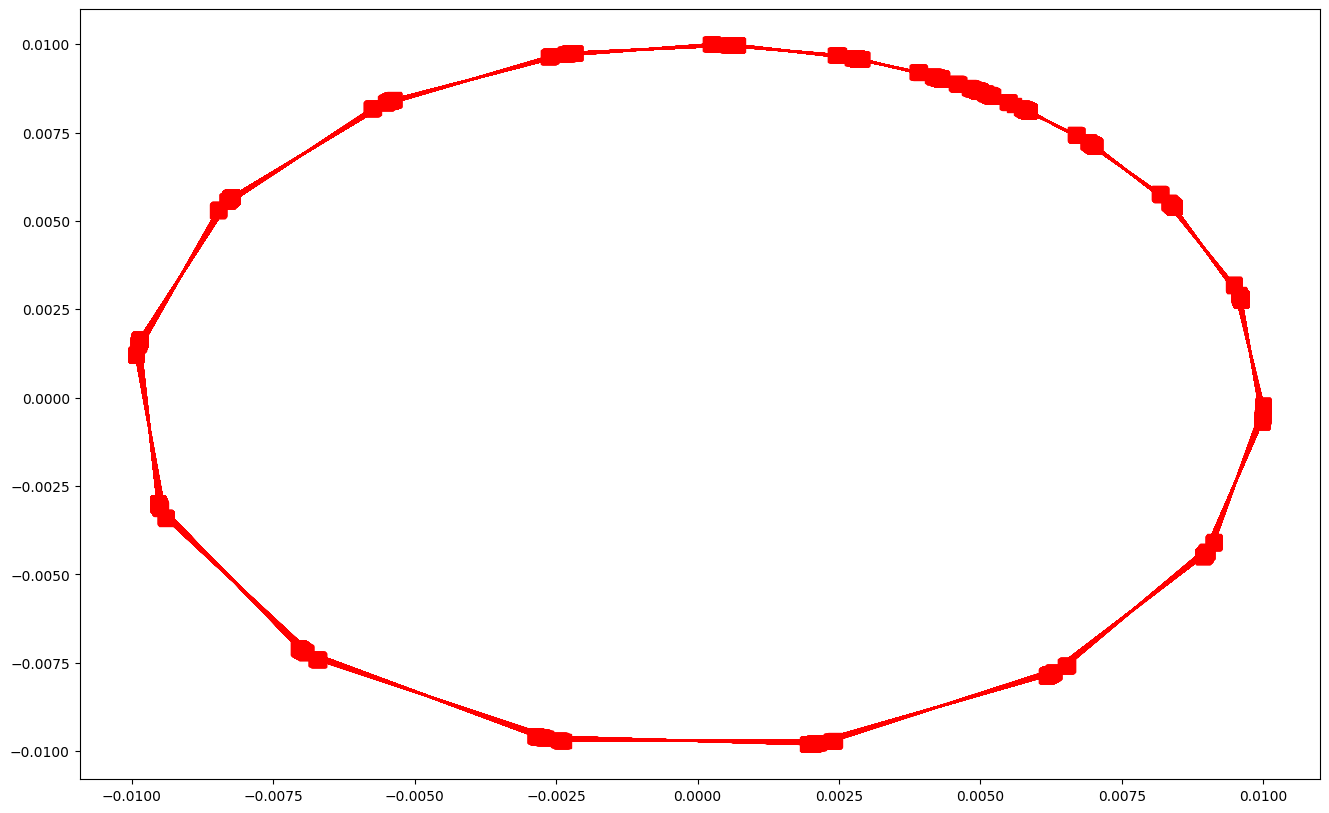

In [352]:

target_data_sample_real = [target_data_sample.real for target_data_sample in complex_interesting_bin]
target_data_sample_image =[target_data_sample.imag for target_data_sample in complex_interesting_bin]

plt.figure(figsize=(16, 10))
plt.plot(target_data_sample_real, target_data_sample_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(target_data_sample_real, target_data_sample_image, color='red')
plt.show()

In [353]:
def extractPhase(interestingRangeBin):
    interestingRangeBinLen =len(interestingRangeBin)
    phaseExtracted = np.zeros(len(interestingRangeBin),dtype=float)
    phaseExtracted[0]=np.angle(interestingRangeBin[0])
    
    for i in range(1,interestingRangeBinLen):        
        tmpPhase =0
        for j in range(1,i):
            I_k=interestingRangeBin[j].real
            Q_k=interestingRangeBin[j].imag
            I_k_prev=interestingRangeBin[j-1].real
            Q_k_prev=interestingRangeBin[j-1].imag
            tmpPhase+= (I_k * (Q_k - Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k**2 + Q_k **2)

        phaseExtracted[i]= tmpPhase
    return phaseExtracted

In [354]:
extracted= extractPhase(np.array(rangeProfiles)[:,50])


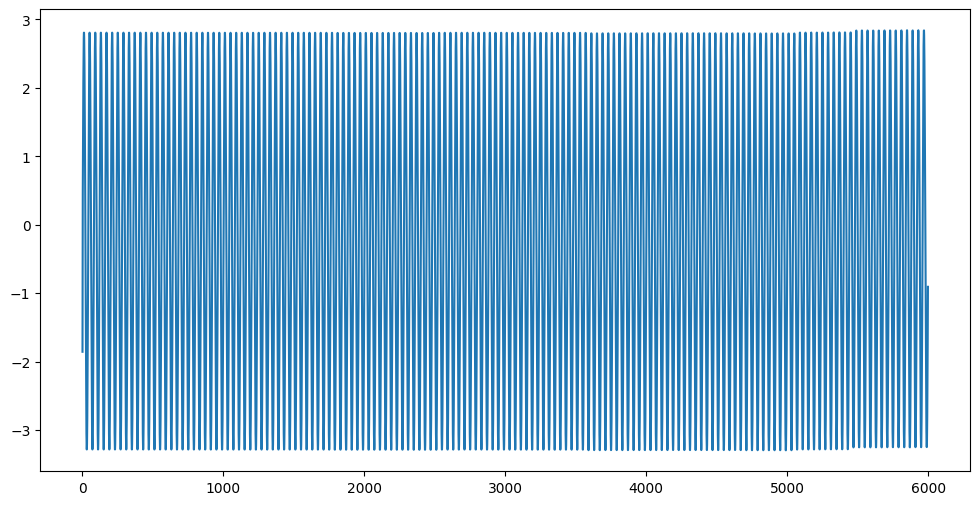

In [355]:
plt.figure(figsize=(12,6))
plt.plot(extracted)
plt.show()

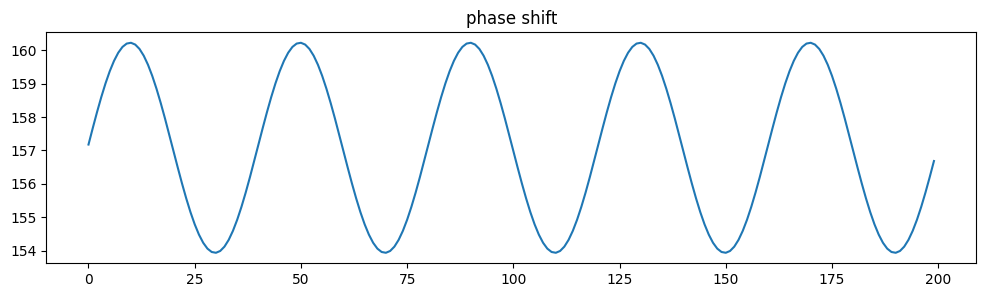

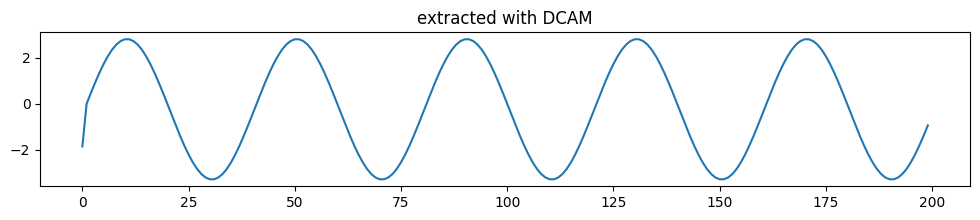

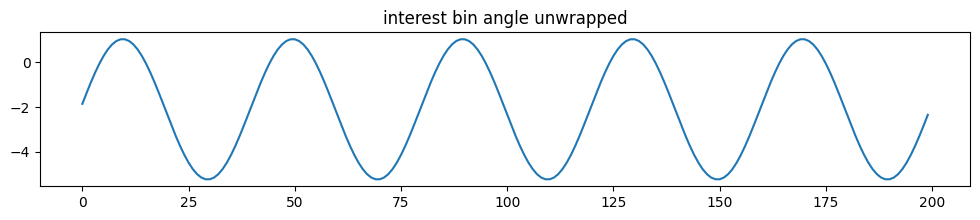

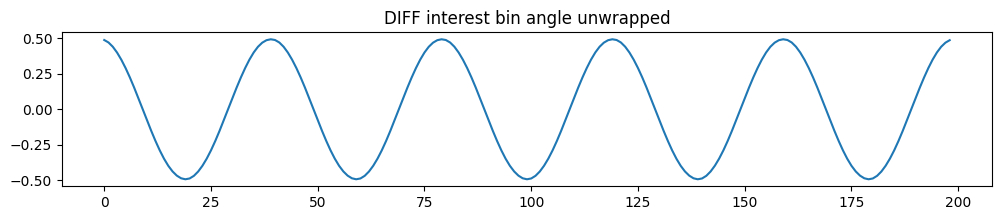

In [356]:
range_plot=20*10
tmp_phase_shift = phase_shift.reshape(Nd,Nr)
tmp_phase_shift_interesting =np.array(tmp_phase_shift)[:,interesting_bin]
plt.figure(figsize=(12,3))
plt.plot(tmp_phase_shift_interesting[:range_plot])
plt.title("phase shift")
plt.show()

plt.figure(figsize=(12,2))
plt.plot(extracted[:range_plot])
plt.title("extracted with DCAM")
plt.show()

plt.figure(figsize=(12,2))
plt.plot(interest_bin_angle_unwrapped[:range_plot])
plt.title("interest bin angle unwrapped")
plt.show()


plt.figure(figsize=(12,2))
plt.plot(np.diff(interest_bin_angle_unwrapped[:range_plot]))
plt.title("DIFF interest bin angle unwrapped")
plt.show()



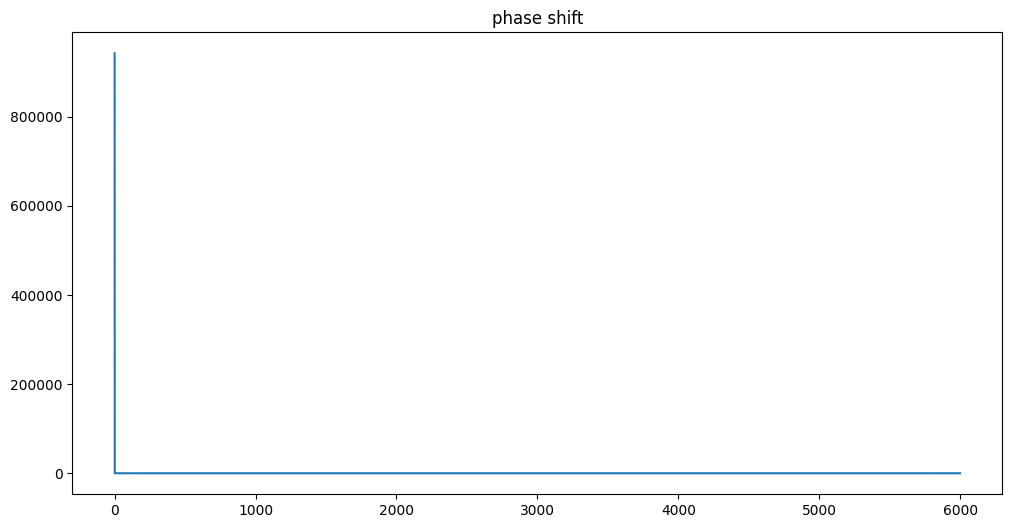

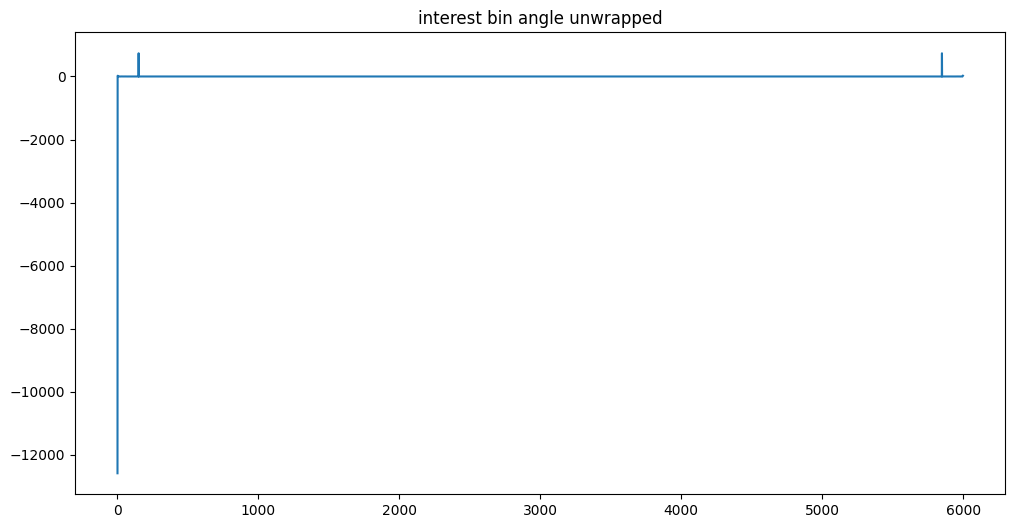

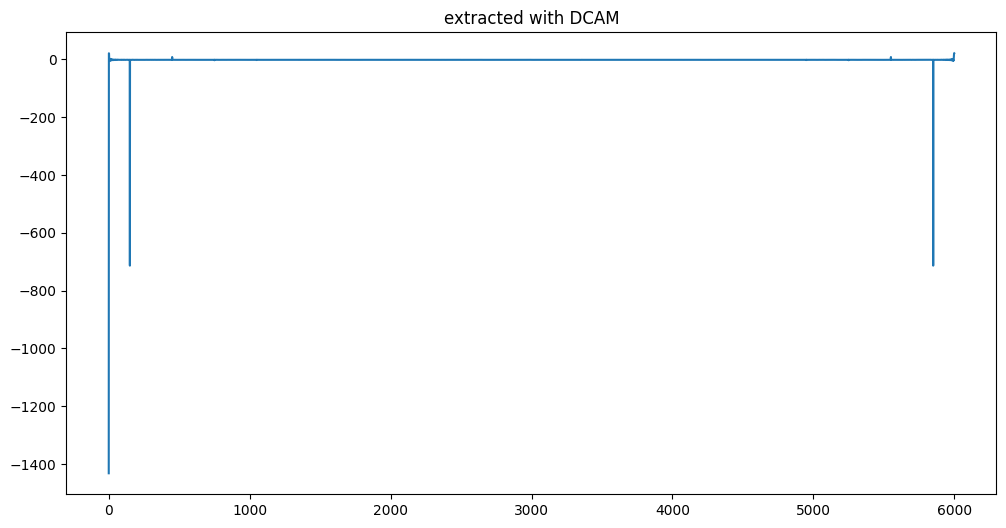

In [357]:
plt.figure(figsize=(12,6))

plt.plot(np.fft.fft(tmp_phase_shift_interesting))
plt.title("phase shift")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.fft.fft(interest_bin_angle_unwrapped))
plt.title("interest bin angle unwrapped")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.fft.fft(extracted))
plt.title("extracted with DCAM")
plt.show()

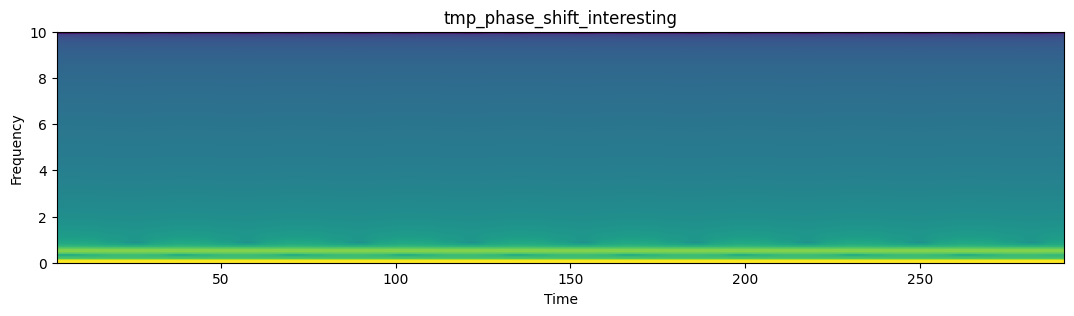

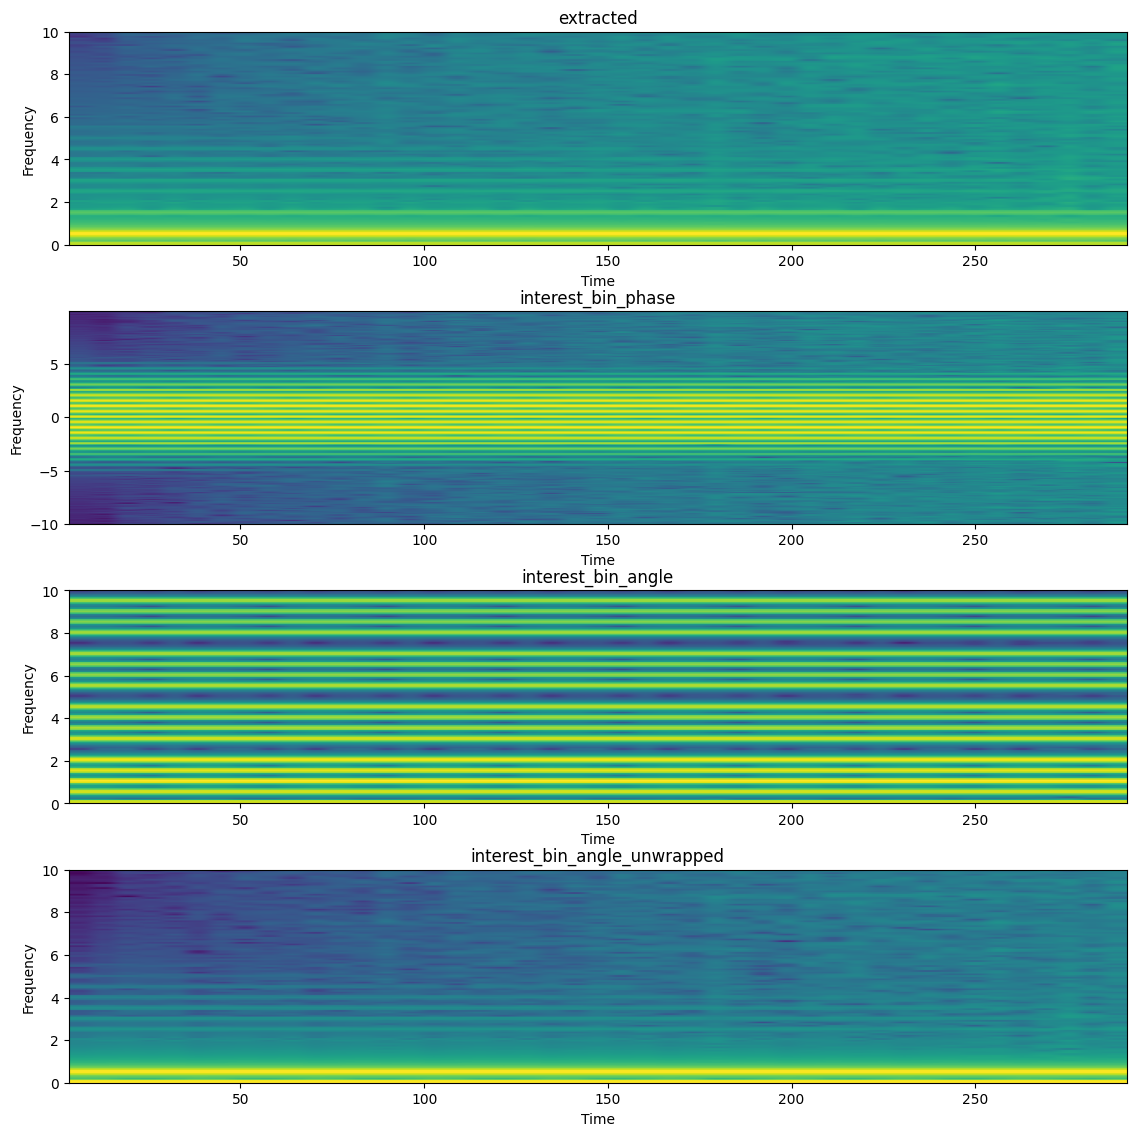

In [367]:
# interest_bin_angle = np.angle(interest_bin_phase)
# interest_bin_angle_unwrapped= np.unwrap(interest_bin_angle)



plt.figure(figsize=(14,3))

plt.specgram(tmp_phase_shift_interesting,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('tmp_phase_shift_interesting')
plt.show()

plt.figure(figsize=(12,12))
plt.subplot(411)
plt.specgram(extracted,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('extracted')


plt.subplot(412)
plt.specgram(interest_bin_phase,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_phase')


plt.subplot(413)
plt.specgram(interest_bin_angle,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_angle')


plt.subplot(414)
plt.specgram(interest_bin_angle_unwrapped,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_angle_unwrapped')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()
